In [154]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

from tqdm import tqdm_notebook

In [4]:
df_env_alpha = pd.read_csv('../own_data/1905_features/env_alpha_ep3.csv')
df_env_beta = pd.read_csv('../own_data/1905_features/env_beta_ep3.csv')
df_coh_alpha = pd.read_csv('../own_data/1905_features/coh_alpha_ep3.csv')
df_coh_beta = pd.read_csv('../own_data/1905_features/coh_beta_ep3.csv')

In [6]:
df = df_env_alpha.copy()

In [7]:
features = [col for col in df.columns if col not in ['dataset', 'fn', 'is_patient']]

In [12]:
X = df[features].values
y = df['is_patient'].values

In [145]:
def run_exper_1(X, y, random_state=42):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    pr = []
    rec = []

    y_score = np.empty(len(y))
    for train_idx, test_idx in cv.split(X, y):
        model = LogisticRegression(solver='liblinear')
        model.fit(X[train_idx, :], y[train_idx])
        y_score[test_idx] = model.predict_proba(X[test_idx, :])[:, 1]
    
    roc_auc = roc_auc_score(y, y_score)
    acc = accuracy_score(y, y_score > 0.5)
    return {'roc_auc': roc_auc, 'acc': acc}

In [174]:
def test_depenency_from_n(run_exper=None):
    n_total = X.shape[0]
    rows = []

    for n in tqdm_notebook(range(30, n_total)):
        for iter_idx in range(100):
            random_state = np.random.choice(np.arange(1000))
            idx = np.random.choice(np.arange(89), size=n, replace=False)
            res = run_exper(X[idx], y[idx], random_state=random_state)
            d = {
                'n': n,
                'iter_idx': iter_idx,
                'roc_auc': res['roc_auc'],
                'acc': res['acc']
            }
            rows.append(d)

    res_df_stage = pd.DataFrame(rows)

    res_df_stage_21 = res_df_stage.groupby(
        'n')['roc_auc', 'acc'].mean(
    ).rename(
        columns={
            'roc_auc': 'roc_auc_mean',
            'acc': 'acc_mean',
    })

    res_df_stage_22 = res_df_stage.groupby(
        'n')['roc_auc', 'acc'].std(
    ).rename(
        columns={
            'roc_auc': 'roc_auc_std',
            'acc': 'acc_std',
    })

    res_df = pd.concat([res_df_stage_21, res_df_stage_22], axis=1)
    return res_df

In [146]:
res_df = test_depenency_from_n(run_exper=run_exper_1)

/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in

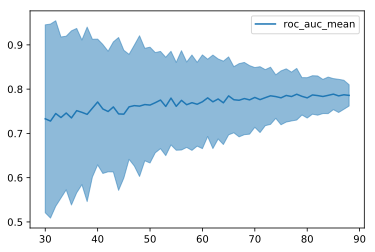

In [142]:


pal = sns.color_palette()

plt.plot(res_df['roc_auc_mean'], label='roc_auc_mean')
plt.legend()
plt.fill_between(res_df['roc_auc_mean'].index,
                 res_df['roc_auc_mean'] - res_df['roc_auc_std'] * 1.96, 
                 res_df['roc_auc_mean'] + res_df['roc_auc_std'] * 1.96,
                 alpha=0.5,
                 color=pal[0])

In [162]:
model = PolyFeatsNoOutliers(X, y, cv='loo', random_state=42)

In [163]:
model.get_roc_auc()

0.7621212121212122

In [167]:
class BaseModel(object):
    """Aim of this class is to provide fast calculation
    of results and metrics that are needed for each model
    """

    def __init__(self, X, y, cv='loo', random_state=42, *args, **kwargs):
        self.y_pred = np.zeros(shape=y.shape)
        self.y_true = y
        self.random_state=random_state
        self.cv = cv
        if cv == 'loo':
            self.cv = LeaveOneOut()
        elif cv == '5fold':
            # self.cv = StratifiedKFold(n_splits=5)
            self.cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        elif cv == '10fold':
            # self.cv = StratifiedKFold(n_splits=10)
            self.cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
        else:
            raise ValueError('wrong value of the cv parameter')
        self._run(X, y, *args, **kwargs)

    def _run(self, X, y, *args, **kwargs):
        """Need to be redefined"""
        raise NotImplementedError

    def get_roc_auc(self):
        return roc_auc_score(self.y_true, self.y_pred)

    def get_accuracy(self):
        return accuracy_score(self.y_true, self.y_pred > 0.5)

    def get_outliers_idx(self, n_outliers=5):
        outliers_idx = (
            np.argsort(
                np.abs(self.y_pred - self.y_true))
            [::-1]
            [:n_outliers])
        return outliers_idx

    def get_ypred_df(self):
        df = pd.DataFrame({'y_true': self.y_true, 'y_pred': self.y_pred})
        return df


class LinearModelPolyFeats(BaseModel):

    def _run(self, X, y, *args, **kwargs):

#         X_poly = PolynomialFeatures(include_bias=False).fit_transform(X)
        X_poly = X
        X_poly = StandardScaler().fit_transform(X_poly)

        for train_idx, test_idx in self.cv.split(X, y):
            model = LogisticRegression(solver='liblinear')
            model.fit(X_poly[train_idx, :], y[train_idx])
            self.y_pred[test_idx] = model.predict_proba(X_poly[test_idx, :])[:, 1]
    
class PolyFeatsNoOutliers(BaseModel):

    def _run(self, X, y, to_drop=[], *args, **kwargs):
        
#         X_poly = PolynomialFeatures(include_bias=False).fit_transform(X)
        X_poly = X
        X_poly = StandardScaler().fit_transform(X_poly)

        for train_idx, test_idx in self.cv.split(X, y):
            train_idx = [idx for idx in train_idx if idx not in to_drop]
            model = LogisticRegression(solver='liblinear')
            model.fit(X_poly[train_idx, :], y[train_idx])
            self.y_pred[test_idx] = model.predict_proba(X_poly[test_idx, :])[:, 1]

In [171]:
def run_exper_2(X, y, random_state=42):
    model_1 = LinearModelPolyFeats(X, y, cv='10fold', random_state=random_state)
    model_2 = PolyFeatsNoOutliers(X, y, cv='10fold', random_state=random_state, 
                                  to_drop=model_1.get_outliers_idx(n_outliers=10))
    
    roc_auc = model_2.get_roc_auc()
    acc = model_2.get_accuracy()
    return {'roc_auc': roc_auc, 'acc': acc}

In [175]:
res_df = test_depenency_from_n(run_exper=run_exper_2)

/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ledovsky/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


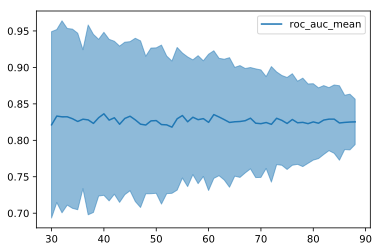

In [176]:
pal = sns.color_palette()

plt.plot(res_df['roc_auc_mean'], label='roc_auc_mean')
plt.legend()
plt.fill_between(res_df['roc_auc_mean'].index,
                 res_df['roc_auc_mean'] - res_df['roc_auc_std'] * 1.96, 
                 res_df['roc_auc_mean'] + res_df['roc_auc_std'] * 1.96,
                 alpha=0.5,
                 color=pal[0])

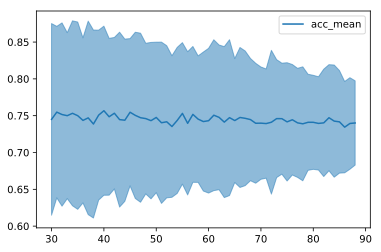

In [178]:
pal = sns.color_palette()

plt.plot(res_df['acc_mean'], label='acc_mean')
plt.legend()
plt.fill_between(res_df['acc_mean'].index,
                 res_df['acc_mean'] - res_df['acc_std'] * 1.96, 
                 res_df['acc_mean'] + res_df['acc_std'] * 1.96,
                 alpha=0.5,
                 color=pal[0])